# Train Models

In [1]:
# Author information
__author__ = "Troy Reynolds"
__email__ = "Troy.Lloyd.Reynolds@gmail.com"

In [2]:
# libraries
import pandas as pd
import numpy as np
import sys
import os


# processing libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# model libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Extend the directory to get created functions
sys.path.insert(0, "./function_scripts")
sys.path.insert(0, "./results")

# import helper functions
from data_import_functions import get_data
from Preprocessing import cv_mse_stats
from results import display_search_results, save_results, save_model
from results import plot_results, plot_feature_importance

In [3]:
# load in the data
data = get_data("train", key = "jobId", target_variable = "salary", remove_zeros = True)

# drop id variables besides JobID for pairing in baseline regressor
features = data.drop(["jobId","companyId", "salary"], axis = 1)
target = data["salary"]

# Preview of original features
features.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,CFO,MASTERS,MATH,HEALTH,10,83
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


## Model Proposal
As discussed in the baseline model notebook, the proposed models will be split into 2 categories: linear model and tree-based model.

<u>Linear Model:</u> The linear models proposed based on Ridge regression because all features are correlated with the target variable and thus valuable. Lasso Regression is added with the addition of polynomial features for potential feature selection.
* [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* Polynomial Linear Regression 
* [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
* Polynomial Ridge Regression 

<u>Tree-based Model:</u>
* [Random-Forest Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [XGBoost Regresssor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

## Preprocessing Pipelines

#### <u>Linear Model Pipeline:</u>
As discussed in the previous notebook, the best tested transformations were one-hot-encding and standard scaling.

In [4]:
# variable grouping
cat_var = ["jobType", "major", "industry", "degree"]
num_var = ["yearsExperience", "milesFromMetropolis"]

# Column Transformer
feature_processing = ColumnTransformer([
    ("cat", OneHotEncoder(drop = "first"), cat_var),
    ("num", StandardScaler(), num_var)
])

# fit the features
preprocessed_features = feature_processing.fit_transform(features)

#### <u>Linear Model Pipeline with Polynomial Features:</u>

In [5]:
# pipleine
polynomial_pipeline = Pipeline([
    ("preprocess", feature_processing), # use previous column transformer
    ("polynomial", PolynomialFeatures(degree = 2))
])

# fit the features
poly_features = polynomial_pipeline.fit_transform(features)

#### <u>Random Forest and XGBoost Pipeline:</u>
Tree-based models are robust to most issues that hinder linear models. The features will not be scaled since those preprocessing techniques can hinder tree-based model performances. Furthermore, the lack of scaling will increase interpretability of the model.

In [6]:
# pipeline
tree_processing = ColumnTransformer(
    # Note: random forest cannot use sparse data
    [("cat", OneHotEncoder(drop = "first", sparse = False), cat_var)], 
    remainder = "passthrough" # does not touch num variables
)

# fit the features
tree_features = tree_processing.fit_transform(features)

## Linear Model Tuning

#### <u>Linear Regression:</u>
Linear Regression using [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn does not need any hyperparameter tuning. So, we shall run the model and collect the resulting MSE.

In [7]:
# mse storage
results = []

# initialize linear regressor
lin = LinearRegression()

# fit data
results.append(cv_mse_stats("linear", lin, preprocessed_features, target))

#### <u>Polynomial Linear Regression:</u>

In [8]:
# fit data
results.append(cv_mse_stats("polynomial linear", lin, poly_features, target))

#### <u>Ridge Regression:</u>
Ridge regression does have hyperparameter tuning involved.

In [9]:
# Initialize model
ridge_reg = Ridge(random_state = 42)

# param_grid
param_ridge = [{
    "alpha": [0.3, 1, 3, 5, 10],
    "max_iter": [30, 50, 75, 100],
}]

# initialize grid search
grid_search_ridge = GridSearchCV(ridge_reg, 
                                 param_ridge, 
                                 scoring = "neg_mean_squared_error", 
                                 cv = 5, 
                                 n_jobs = 4, 
                                 verbose = 1)

# run grid search
%time grid_search_ridge.fit(preprocessed_features, target)
print("Best Parameters: ", grid_search_ridge.best_params_)
print("Best MSE:        ", -1*grid_search_ridge.best_score_)

# save result
results.append(cv_mse_stats("Ridge", 
                            Ridge(random_state = 42, **grid_search_ridge.best_params_), 
                            preprocessed_features, 
                            target))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 30.1 s
Best Parameters:  {'alpha': 1, 'max_iter': 30}
Best MSE:         384.44400430425


#### <u>Polynomial Ridge Regression:</u>

In [10]:
# Initialize model
ridge_reg = Ridge(random_state = 42)

# param_grid
param_poly_ridge = [{
    "alpha": [0.3, 1, 3, 5, 10],
    "max_iter": [30, 50, 75, 100],
}]

# initialize grid search
grid_search_poly_ridge = GridSearchCV(ridge_reg, 
                                      param_poly_ridge, 
                                      scoring = "neg_mean_squared_error", 
                                      cv = 5, 
                                      n_jobs = 4, 
                                      verbose = 1)

# run grid search
%time grid_search_poly_ridge.fit(poly_features, target)
print("Best Parameters: ", grid_search_poly_ridge.best_params_)
print("Best MSE:        ", -1*grid_search_poly_ridge.best_score_)

# save result
results.append(cv_mse_stats("Polynomial Ridge", 
                            Ridge(random_state = 42, **grid_search_poly_ridge.best_params_), 
                            poly_features, 
                            target))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 2min 50s
Best Parameters:  {'alpha': 3, 'max_iter': 50}
Best MSE:         354.08973521080924


## Tree-Based Model Tuning

#### Random Forest Regressor

In [11]:
# Initialize model
rf_reg = RandomForestRegressor(random_state = 42)

# initialize parameter grid
param_rf = [{
    "max_depth": [int(x) for x in np.linspace(0, 80, num = 20)],
    "n_estimators": [int(x) for x in np.linspace(0, 120, num = 20)],
    "min_samples_split": [int(x) for x in np.linspace(0, 25,num = 20)],
    "max_features": ["auto", "sqrt"]
}]

# initialize randomized grid search
rand_search_rf = RandomizedSearchCV(rf_reg, 
                                    param_rf, 
                                    cv = 3, 
                                    scoring = "neg_mean_squared_error", 
                                    n_jobs = 4, 
                                    verbose = 1, 
                                    random_state = 42)
# run randomized grid search
%time rand_search_rf.fit(tree_features, target)
print("Best Parameters: ", rand_search_rf.best_params_)
print("Best MSE:        ", rand_search_rf.best_score_)

# display results from randomized grid search
display_search_results(rand_search_rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Troyr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-437.06953589 -380.06846793           nan -379.3729981  -376.46459828
 -376.1914309  -372.99635672 -424.26113356 -405.31622241 -374.78617066]
  warnings.warn(


Wall time: 25min 13s
Best Parameters:  {'n_estimators': 25, 'min_samples_split': 23, 'max_features': 'sqrt', 'max_depth': 58}
Best MSE:         -372.99635672013824


,n_estimators,min_samples_split,max_features,max_depth,mean_test_score
0,63,3,auto,37,-437.069536
7,25,5,auto,58,-424.261134
8,88,7,auto,29,-405.316222
1,94,11,sqrt,80,-380.068468
3,63,11,sqrt,25,-379.372998
4,113,13,sqrt,67,-376.464598
5,69,25,auto,25,-376.191431
9,31,17,sqrt,29,-374.786171
6,25,23,sqrt,58,-372.996357
2,0,3,auto,4,NaN


In [12]:
# grid search parameters
param_rf = [{
    "max_depth": [30, 35],
    "n_estimators": [110, 120, 130],
    "min_samples_split": [30, 35, 40],
    "max_features": ["sqrt"]
}]

# initialize grid search
grid_search_rf = GridSearchCV(rf_reg, 
                              param_rf, 
                              cv = 3, 
                              scoring = "neg_mean_squared_error", 
                              n_jobs = 4, 
                              verbose = 1)
# run grid search
%time grid_search_rf.fit(tree_features, target)
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best MSE:        ", grid_search_rf.best_score_)

# save result
results.append(cv_mse_stats("Random Forest", 
                            RandomForestRegressor(random_state = 42, **grid_search_rf.best_params_), 
                            tree_features, 
                            target))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Wall time: 49min 41s
Best Parameters:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 35, 'n_estimators': 120}
Best MSE:         -368.7077445951945


#### XGBoost Regressor

In [13]:
### Grid Search to get the best params
xgb_reg = XGBRegressor(random_state = 42)

param_xgb_reg = [{
    "max_depth": [5, 7, 10],
    "n_estimators": [20, 30, 40, 50],
}]

grid_search_xgb_reg = GridSearchCV(xgb_reg, 
                                   param_xgb_reg,
                                   scoring = "neg_mean_squared_error", 
                                   cv = 3,
                                   n_jobs = 1,
                                   verbose = 1)

# run grid search
%time grid_search_xgb_reg.fit(tree_features, target)
print("Best Parameters: ", grid_search_xgb_reg.best_params_)
print("Best MSE:        ", grid_search_xgb_reg.best_score_)

# display results from randomized grid search
display_search_results(grid_search_xgb_reg)

# save result
results.append(cv_mse_stats("XGBoost Regressor", 
                            XGBRegressor(random_state = 42, **grid_search_xgb_reg.best_params_), 
                            tree_features, 
                            target))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Wall time: 9min 1s
Best Parameters:  {'max_depth': 7, 'n_estimators': 50}
Best MSE:         -360.59059680412764


## Results
Out of all the models, the polynomial linear regression preformed the best. The model improved the baseline linear regression MSE by 11.5%. 

Saving figure Model Results
Results Saved to .\results\Model_MSE_results.plk.pkl


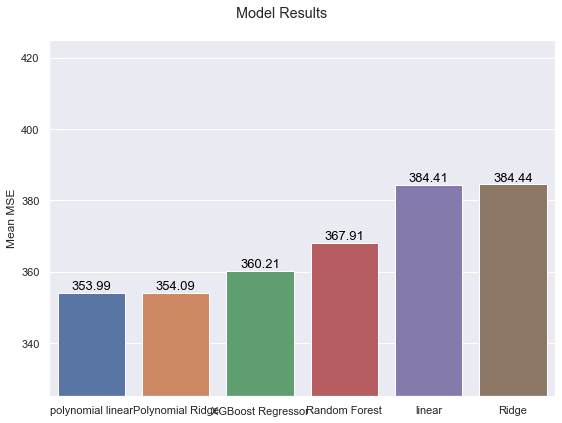

In [14]:
# organize results storage
results_df = pd.DataFrame(data = results, columns = ["Name", "Mean MSE", "Std MSE"])
results_sorted = results_df.sort_values(by = "Mean MSE", ignore_index = True)

# plot the results
plot_results(results_sorted, "Model Results")

# save results
save_results(results_sorted, "Model_MSE_results")

In [15]:
# save the best model for test predictions
best_model = LinearRegression()
best_model.fit(poly_features, target)
save_model(best_model, "best_model")

# save feature transformation pipeline
save_model(polynomial_pipeline, "pipeline")

Results Saved to .\model\best_model.pkl
Results Saved to .\model\pipeline.pkl


## Feature Importance
The most impactful features are presented below. The 2 most important variables were whether the job listing was for a janitor or a junior position. The least impactful features came from the different majors.

In [16]:
# fit xgboost regressor to get feature importances
xgb = XGBRegressor(random_state = 42, **grid_search_xgb_reg.best_params_)
xgb.fit(tree_features, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Saving figure XGBOOST FEATURE IMPORTANCE


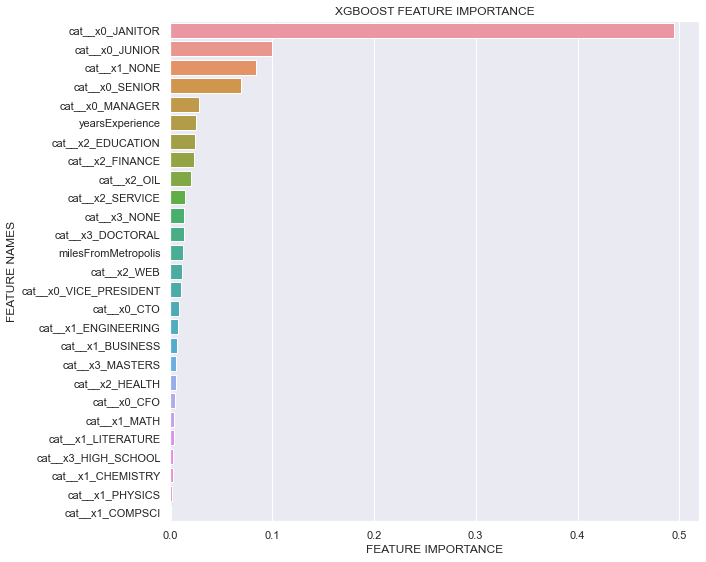

In [17]:
# plot importances
importance = xgb.feature_importances_
names = tree_processing.get_feature_names()
plot_feature_importance(importance, names)